# Fake Job Posting Prediction

## Topic and Goal

I was interested in fake job postings after witnessing numerous cases where software developers got scammed out of fake job postings during tech layoffs period. I figured this could be good opportunity for me to learn how to identify fake job postings using NLP such as BiLSTM and CNN, which is the deep learning model that I learnt in week 4.  
The dataset contains 18K job descriptions out of which about 800 are fake. The data consists of both textual information and meta-information about the jobs. The dataset can be used to create classification models which can learn the job descriptions which are fraudulent. The goal is to use NLP to identify key traits/features (words, entities, phrases) of job descriptions which are fraudulent in nature.
Here is the link for the data: https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction/data


In [46]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import plotly.express as px
import re
import nltk
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import tensorflow as tf
tokenizer = tf.keras.preprocessing.text.Tokenizer
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Embedding, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.python.keras.layers.recurrent import LSTM, GRU 
adam = tf.keras.optimizers.Adam
from tensorflow.python.keras.callbacks import EarlyStopping
bi_directional = tf.keras.layers.Bidirectional

import warnings 
warnings.filterwarnings('ignore')

## Initial Look

In [2]:
data = pd.read_csv('./data/fake_job_postings.csv')

print(data.head())

   job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Foo

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [4]:
missing_values = data.isnull().sum()
missing_values_percentage = (missing_values / len(data)) * 100

missing_data_summary = pd.DataFrame({"Missing Values": missing_values, 
                                     "Percentage": missing_values_percentage})
missing_data_summary

,Missing Values,Percentage
job_id,0,0.000000
title,0,0.000000
location,346,1.935123
department,11547,64.580537
salary_range,15012,83.959732
company_profile,3308,18.501119
description,1,0.005593
requirements,2696,15.078300
benefits,7212,40.335570
telecommuting,0,0.000000


In [5]:
print("Fraudulent Value Counts:")
print(data['fraudulent'].value_counts())

Fraudulent Value Counts:
fraudulent
0    17014
1      866
Name: count, dtype: int64


The fake job postings data consists of 18 columns. There are over 17880 entries and 866 of them are fake which is identified by `fradulent` column.
There are 10 columns with thousands of NaN, which requires clean up. Instead of deleting the entry, I'll replace the value.

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [6]:
# For text columns, replace missing values with an empty string
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
data[text_columns] = data[text_columns].fillna(' ')

In [7]:
data['location'].fillna('Unknown', inplace=True)
data['department'].fillna('Unknown', inplace=True)
data['salary_range'].fillna('Not Specified', inplace=True)
data['employment_type'].fillna('Not Specified', inplace=True)
data['required_experience'].fillna('Not Specified', inplace=True)
data['required_education'].fillna('Not Specified', inplace=True)
data['industry'].fillna('Not Specified', inplace=True)
data['function'].fillna('Not Specified', inplace=True)

In [8]:
categorical=[]
numerical=[]

for col in data.columns:
    if data[col].dtypes !='object':
            numerical.append(col)
    else:
        categorical.append(col)

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/judoboyalex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
# Text preprocessing function
stop_words = set(nltk.corpus.stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = [word for word in text.split() if word not in stop_words]
    return ' '.join(text)

In [11]:
# For text columns, replace missing values with an empty string
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
data[text_columns] = data[text_columns].fillna(' ')

In [12]:
# Apply preprocessing to text columns
for col in text_columns:
    data[col] = data[col].apply(preprocess_text)

In [13]:
# Combining text columns into a single feature
data['combined_text'] = data[text_columns].apply(lambda x: ' '.join(x), axis=1)

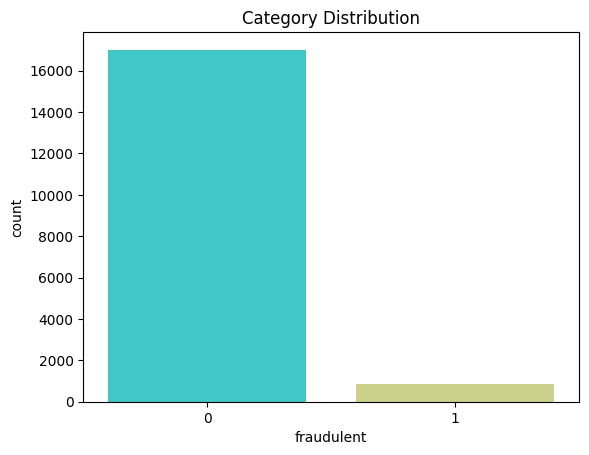

In [14]:
sns.countplot(data = data, x='fraudulent', palette='rainbow')
plt.title('Category Distribution')
plt.show()

Text(0, 0.5, 'No. of Jobs')

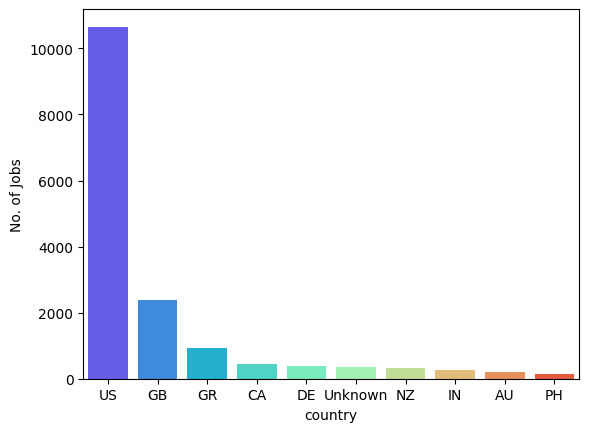

In [15]:
data['country'] = data['location'].str.split(',').str[0]
country = data['country'].value_counts().nlargest(10).index.tolist()
ax=sns.countplot(data=data, x='country', order=country, palette='rainbow')
ax.set_ylabel('No. of Jobs')

Text(0, 0.5, 'No. of Jobs')

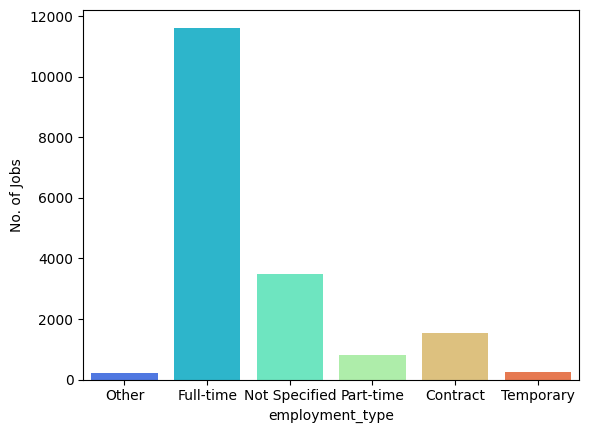

In [16]:
ax=sns.countplot(data=data, x='employment_type', palette='rainbow')
ax.set_ylabel('No. of Jobs')

<Axes: >

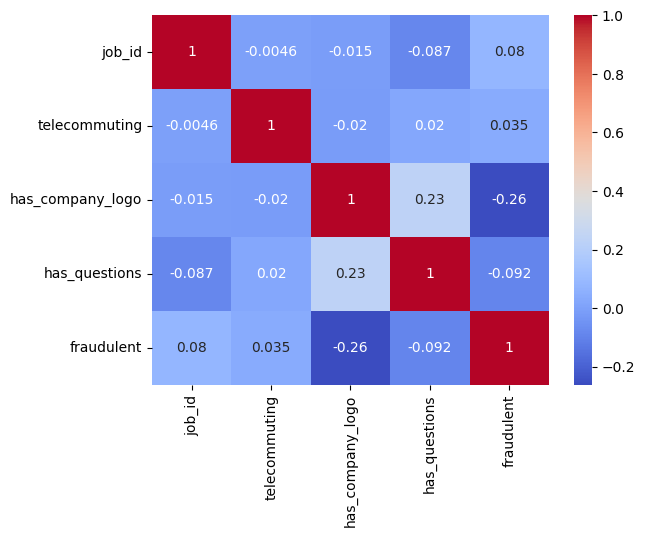

In [17]:
sns.heatmap(data[numerical].corr(), cmap='coolwarm', annot=True)

There is significant more non-fraudulent job postings. Other than that there are nothing significant to take away from these visualization data. 

In [18]:
# Top words in fraudulent job postings
fraudulent_jobs = data[data['fraudulent'] == 1]['combined_text']
non_fraudulent_jobs = data[data['fraudulent'] == 0]['combined_text']

def plot_top_words(text, title):
    word_freq = pd.Series(' '.join(text).split()).value_counts().head(20)
    fig = px.bar(word_freq, x=word_freq.index, y=word_freq.values, title=title,
                 labels={'index': 'Words', 'y': 'Frequency'},
                 color=word_freq.values, color_continuous_scale='Blues')
    fig.update_layout(template='plotly_dark')
    fig.show()

plot_top_words(fraudulent_jobs, 'Top Words in Fraudulent Job Postings')
plot_top_words(non_fraudulent_jobs, 'Top Words in Non-Fraudulent Job Postings')

**Top Words in Fraudulent Job Posting**

Work: The most frequent word, appearing over 1,600 times.
Experience: Commonly mentioned, indicating an emphasis on prior job experience.
Skills: Highlighting the necessity of particular abilities.
Amp: Likely due to formatting issues in the dataset.
Team: Stressing the importance of team dynamics.
Other notable words include company, management, business, service, customer, position, time, engineering, data, project, services, new, ability, years, and solutions.

**Top Words in Non-Fraudulent Job Postings**

Work: Also the most frequent word, appearing over 35,000 times.
Experience: Similarly emphasized, appearing frequently.
Team: Suggesting a focus on collaborative work environments.
Business: Indicative of a professional and corporate setting.
Company: Mentioned frequently, likely referring to the hiring organization.
Other significant words include new, customer, skills, sales, management, development, working, services, amp, service, years, people, looking, marketing, and us.

**Summary**

Both fraudulent and non-fraudulent job postings frequently use terms like work, experience, team, and skills. However, non-fraudulent postings have a higher emphasis on business-related terms like company, business, customer, sales, and management. Fraudulent postings, on the other hand, show a diverse range of terms with a slight focus on management, service, position, and engineering.

In [21]:
# TF-IDF with Character-Level N-Grams
vectorizer = TfidfVectorizer(
    min_df=2, max_df=0.2, 
    analyzer='char_wb', 
    ngram_range=(3,7)
)
X_tfidf = vectorizer.fit_transform(data['combined_text']).toarray()

# Tokenization
tokenizer = tokenizer()
tokenizer.fit_on_texts(data['combined_text'])
train_sequences = tokenizer.texts_to_sequences(data['combined_text'])

# Padding
max_length = max(len(seq) for seq in train_sequences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
train_labels = data['fraudulent'].values

## Model Architecture

I have picked Bidirectional LSTM and CNN to predict fake job postings. 

**Bidirectional Long Short-Term Memory networks(BiLSTMs)** excel at capturing the context and semantics of text:

1. Sequential Context Understanding:

LSTMs process data sequentially, maintaining information from previous words while learning dependencies over time. Bidirectional LSTMs go further by processing text in both forward and backward directions.
This ensures the model considers both preceding and following words for context, making it effective for capturing nuanced patterns in job descriptions.

2. Ability to Handle Long Dependencies:

Fake job postings may contain subtle hints of fraud spread across the text. LSTMs, with their memory cells, are capable of learning these long-term dependencies better than standard RNNs.

3. Semantic Features:

The ability of LSTMs to understand and retain the meaning of words and phrases helps detect misleading or manipulative language, which is common in fraudulent postings.

**Convolutional Neural Networks(CNNs)** are powerful for capturing spatial patterns in text, which translate to local features in sequences:

1. N-gram Feature Extraction:

CNNs can detect key phrases or patterns (like n-grams) that frequently occur in fake job postings. For example, phrases like "quick money," "no experience needed," or "free registration" may be indicative of fraud.

2. Efficient Feature Detection:

CNN filters slide over the input text embeddings to identify important features such as specific keywords, punctuation, or other textual anomalies that are characteristic of fake postings.

3. Fast and Parallel Processing:

Compared to recurrent models like LSTMs, CNNs are computationally efficient and can process the entire input text in parallel, making them faster for training and inference.

Now let's start with BiLSTM model.

In [22]:
vocabulary_size = len(tokenizer.word_index) + 1

# Create the model
bidirectional_model = tf.keras.Sequential()

# Embedding Layer with explicit input shape
bidirectional_model.add(tf.keras.layers.Embedding(input_dim=vocabulary_size, output_dim=100, input_length=max_length))

# Bidirectional LSTM Layer
bidirectional_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, dropout=0.2, recurrent_dropout=0.2)))

# Fully Connected Layer
bidirectional_model.add(tf.keras.layers.Dense(units=64, activation='relu'))

# Dropout for Regularization
bidirectional_model.add(tf.keras.layers.Dropout(0.5))

# Output Layer
bidirectional_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Build the model
bidirectional_model.build(input_shape=(None, max_length))

# Compile the model
bidirectional_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
bidirectional_model.summary()

# Model fitting
bidirectional_model.fit(train_padded, train_labels, epochs=5, batch_size=64, validation_split=0.2)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1383, 100)      │    15,946,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,197,109 (61.79 MB)

 Trainable params: 16,197,109 (61.79 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 533s 2s/step - accuracy: 0.9549 - loss: 0.2035 - val_accuracy: 0.9536 - val_loss: 0.1563
Epoch 2/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 634s 3s/step - accuracy: 0.9905 - loss: 0.0322 - val_accuracy: 0.9567 - val_loss: 0.1618
Epoch 3/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 641s 3s/step - accuracy: 0.9970 - loss: 0.0107 - val_accuracy: 0.9547 - val_loss: 0.2156
Epoch 4/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 632s 3s/step - accuracy: 0.9983 - loss: 0.0063 - val_accuracy: 0.9480 - val_loss: 0.2878
Epoch 5/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 625s 3s/step - accuracy: 0.9995 - loss: 0.0019 - val_accuracy: 0.9544 - val_loss: 0.3320


In [54]:
# Learning curve
def learning_curve(history):
    # Access the history attribute correctly as a dictionary
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    
    # Plotting training and validation accuracy
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1])
    plt.title('Training and Validation Accuracy')

    # Plotting training and validation loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0, 1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')

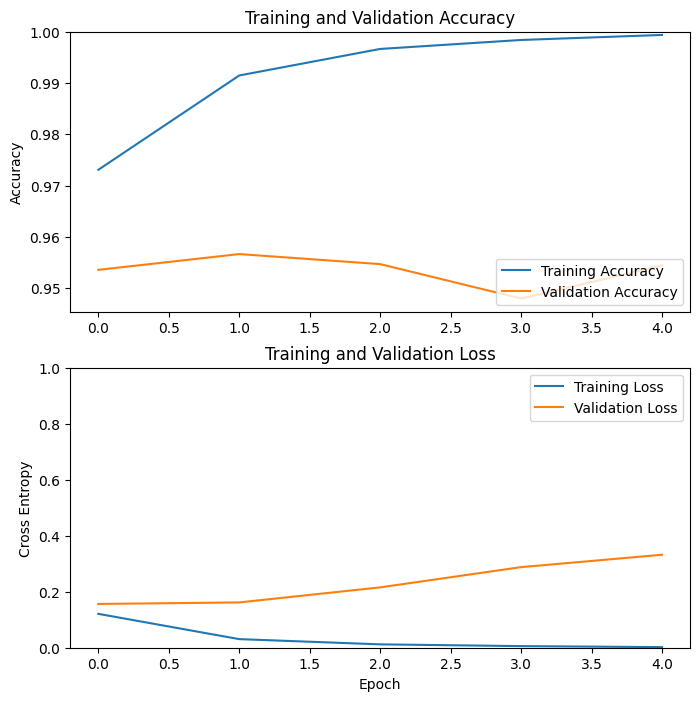

In [56]:
learning_curve(bidirectional_model.history)

With over 0.95 consistent accuracy, BiLSTM is extremely accurate predicting fake job postings.
Now let's checkout how CNN model does.

In [47]:
# Create the model
cnn_model = tf.keras.Sequential()

# Embedding Layer with explicit input shape
cnn_model.add(tf.keras.layers.Embedding(input_dim=vocabulary_size, output_dim=100, input_length=max_length))

# Convolutional Layer
cnn_model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'))

# Max Pooling Layer
cnn_model.add(tf.keras.layers.GlobalMaxPooling1D())

# Fully Connected Layer
cnn_model.add(tf.keras.layers.Dense(units=64, activation='relu'))

# Dropout for Regularization
cnn_model.add(tf.keras.layers.Dropout(0.5))

# Output Layer
cnn_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Build the model
cnn_model.build(input_shape=(None, max_length))

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
cnn_model.summary()

# Model fitting
cnn_model.fit(train_padded, train_labels, epochs=5, batch_size=64, validation_split=0.2)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 1383, 100)      │    15,946,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1379, 128)      │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,018,549 (61.11 MB)

 Trainable params: 16,018,549 (61.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 31s 136ms/step - accuracy: 0.9310 - loss: 0.2437 - val_accuracy: 0.9251 - val_loss: 0.1792
Epoch 2/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - accuracy: 0.9884 - loss: 0.0354 - val_accuracy: 0.9536 - val_loss: 0.1438
Epoch 3/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 31s 137ms/step - accuracy: 0.9995 - loss: 0.0043 - val_accuracy: 0.9555 - val_loss: 0.1755
Epoch 4/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 30s 136ms/step - accuracy: 1.0000 - loss: 9.2633e-04 - val_accuracy: 0.9541 - val_loss: 0.2175
Epoch 5/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - accuracy: 1.0000 - loss: 3.7050e-04 - val_accuracy: 0.9555 - val_loss: 0.2279


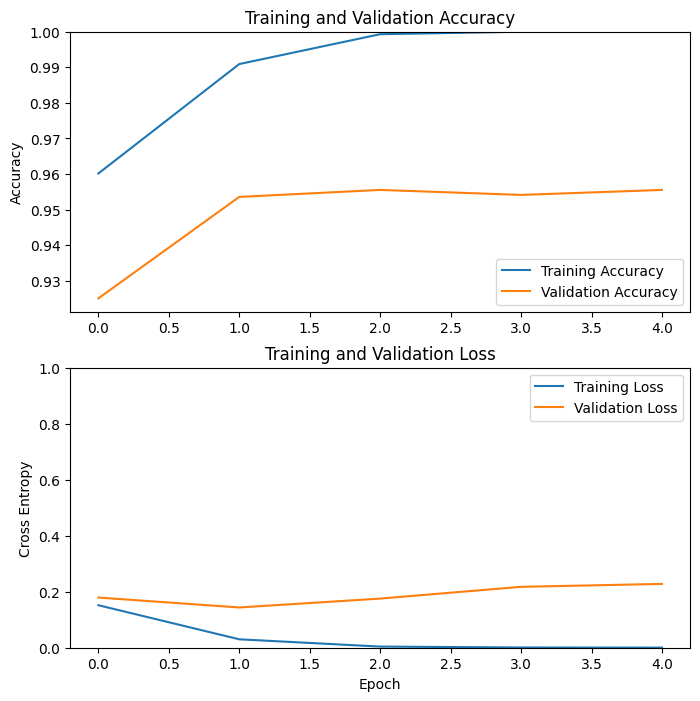

In [57]:
learning_curve(cnn_model.history)

Just as BiLSTM, the CNN model does excellment job with prediction.
I have also tried experimenting with BERT(Bidirectional Encoder Representations) model, but couldn't get it working properly.
BERT is highly effective for predicting fake job postings because of its ability to leverage deep, contextualized understanding of text. It outperforms LSTMs and CNNs in capturing both global and local semantics and in generalizing from pretraining. However, its computational demands and potential overfitting risks make it more suitable for scenarios where sufficient resources and moderately sized datasets are available.

In [ ]:
# Load data
X = data['combined_text']
y = data['fraudulent']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Ensure labels are integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to convert data to InputExample
def convert_data_to_input_examples(texts, labels):
    input_examples = []
    for text, label in zip(texts, labels):
        input_examples.append(InputExample(guid=None, text_a=text, text_b=None, label=label))
    return input_examples

# Convert data to InputExample format
train_examples = convert_data_to_input_examples(X_train, y_train)
test_examples = convert_data_to_input_examples(X_test, y_test)

# Convert InputExample to InputFeatures
def convert_examples_to_tf_dataset(examples, labels, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []

    for example in examples:
        encoded = tokenizer.encode_plus(
            example.text_a,  # Adjusted to use text_a attribute
            add_special_tokens=True,
            max_length=max_length,
            truncation=True,
            padding="max_length",
            return_attention_mask=True,
        )
        input_ids.append(encoded["input_ids"])
        attention_masks.append(encoded["attention_mask"])

    if labels is None:
        raise ValueError("Labels must not be None.")

    # Convert to TensorFlow dataset
    return tf.data.Dataset.from_tensor_slices((
        {
            "input_ids": tf.constant(input_ids, dtype=tf.int32),
            "attention_mask": tf.constant(attention_masks, dtype=tf.int32),
        },
        tf.constant(labels, dtype=tf.int32),
    ))

# Convert datasets to TensorFlow datasets
train_dataset = convert_examples_to_tf_dataset(train_examples, y_train, tokenizer)
train_dataset = train_dataset.shuffle(len(train_examples)).batch(16).prefetch(tf.data.AUTOTUNE)
test_dataset = convert_examples_to_tf_dataset(test_examples, y_test, tokenizer).batch(16).prefetch(tf.data.AUTOTUNE)

# Load BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Compile the model
# optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
model.compile(optimizer='adam', loss=model.compute_loss, metrics=['accuracy'])

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
try:
    history = model.fit(
        train_dataset,
        epochs=3,
        validation_data=test_dataset,
        callbacks=[early_stopping]
    )
except Exception as e:
    print(f"Error during training")

# Evaluate accuracy
try:
    loss, accuracy = model.evaluate(test_dataset)
    print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")
except Exception as e:
    print(f"Error during evaluation")


# Make predictions
y_pred_probs = model.predict(test_dataset).logits
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print(classification_report(y_test, y_pred, target_names=['Not Fraudulent', 'Fraudulent']))

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Error during training
Error during evaluation
224/224 [==============================] - 228s 1s/step
                precision    recall  f1-score   support

Not Fraudulent       0.96      0.81      0.87      3403
    Fraudulent       0.07      0.27      0.10       173

      accuracy                           0.78      3576
     macro avg       0.51      0.54      0.49      3576
  weighted avg       0.91      0.78      0.84      3576



## Results and Analysis

1. Training Accuracy and Loss

BiLSTM:
Training accuracy consistently improves, reaching 99.95% by the 5th epoch, with a final training loss of 0.0019.
This suggests that the BiLSTM model has a high capacity to learn the training data and has almost perfectly fit it.

CNN:
Training accuracy also improves significantly, reaching 100% by the 5th epoch, with a final training loss of 0.00037.
This indicates that the CNN model has achieved perfect training accuracy.

Comparison:
Both models exhibit excellent training performance, but CNN achieves faster convergence (reaching near-perfect accuracy and lower training loss earlier).
This is likely due to the CNN's ability to efficiently capture localized features (e.g., n-grams) with fewer parameters compared to the sequential nature of BiLSTMs.

2. Validation Accuracy and Loss

BiLSTM:
Validation accuracy stabilizes around 95.36%, with a slight decline by the 4th epoch.
Validation loss increases from 0.1563 in the 1st epoch to 0.3320 in the 5th epoch, indicating potential overfitting.

CNN:
Validation accuracy reaches 95.55%, with a slight increase in the later epochs.
Validation loss starts at 0.1792 in the 1st epoch and increases to 0.2279, though the increase is less pronounced compared to BiLSTM.

Comparison:
Both models achieve similar validation accuracy (~95.5%), but CNN has slightly better validation loss behavior, suggesting better generalization.
The BiLSTM may be more prone to overfitting due to its higher capacity and reliance on sequential patterns, which can be redundant or overly complex for the dataset.

3. Training Speed

BiLSTM:
Training is significantly slower, taking approximately ~10 minutes per epoch.
This is due to the sequential processing of the LSTM architecture and the additional parameters introduced by the bidirectional structure.

CNN:
Training is much faster, taking ~30 seconds per epoch.
CNNs process text in parallel and have fewer parameters compared to BiLSTMs, making them computationally efficient.

Comparison:
CNN is significantly faster to train, making it a better choice for situations where computational resources or time is a constraint.

4. Generalization

Both models exhibit similar generalization performance as seen in their validation accuracy.
However, the BiLSTM shows more overfitting, as evidenced by the increasing gap between training and validation loss over epochs.

5. Practical Implications

BiLSTM:
Effective for datasets where sequential dependencies are critical (e.g., long contextual relationships between words).
The slower training speed and susceptibility to overfitting require careful regularization and early stopping.

CNN:
Ideal for datasets where localized patterns (e.g., n-grams) are sufficient to make predictions.
Faster training and less overfitting make it more practical for large-scale or time-sensitive projects.

## Conclusion

1. Performance Similarity:

Both BiLSTM and CNN achieve high validation accuracy (~95.5%) on the fake job postings dataset, indicating their effectiveness in distinguishing fake from genuine job postings.
This suggests that both models are capable of extracting meaningful patterns from the text data to make accurate predictions.

2. Overfitting Behavior:

The BiLSTM exhibits noticeable overfitting, as seen from the increasing validation loss and the near-perfect training accuracy. This may result from its higher capacity and sensitivity to sequential dependencies, which can sometimes overfit the noise in the data.
The CNN, while also achieving near-perfect training accuracy, shows more stable validation loss, indicating better generalization to unseen data.

3. Efficiency in Training:

The CNN is significantly faster to train (~30 seconds per epoch) compared to the BiLSTM (~10 minutes per epoch).
This makes the CNN more practical for large datasets or scenarios where computational resources are limited.

4. Contextual Understanding:

While CNNs rely on capturing local features (e.g., n-grams), the BiLSTM can better model long-term dependencies and sequential relationships, which may be beneficial for more complex datasets requiring deeper contextual understanding.
However, for this dataset, the lack of significant sequential dependencies means CNN achieves comparable results more efficiently.

5. Overall Recommendation:

Given the comparable validation accuracy, faster training, and better generalization, **CNN is the preferred model for predicting fake job postings in this scenario**.
BiLSTM may be more useful if the dataset contains long, complex sentences where understanding the sequence of words is critical.

Future Improvements:

For BiLSTM:
Introduce early stopping and stronger regularization techniques (e.g., dropout, L2 regularization) to mitigate overfitting.

For CNN:
Experiment with deeper architectures (more convolutional layers) or hybrid approaches (e.g., CNN + LSTM) to improve accuracy further without compromising efficiency.